# 9. Measuring Objects

In Week 1, we delved into the basics of object measurement using top-down imagery. Our focus was on straightforward scenarios, like coins laid out flat, allowing us to operate comfortably within a two-dimensional framework. This approach was an excellent starting point for grasping the fundamentals of image-based measurements. However, as we all know, the world around us is not flat. It's a rich, three-dimensional space, full of varying heights, depths, and perspectives. When we capture this 3D world with a camera, it gets projected onto a two-dimensional plane, leading to various challenges in accurately interpreting and measuring objects.

In this notebook, we will take a look what is beyond 2-D by introducing [homography](https://en.wikipedia.org/wiki/Homography_(computer_vision)). Homography is a transformation that describes how a camera captures the 3D world and projects it onto a 2D image. Understanding this will help us correct for perspective distortions and accurately interpret spatial relationships in images.

## 9.1 Find the corners of the paper

Before introducing homography, let's first understand what happens if we have a perspective other than the top down view.

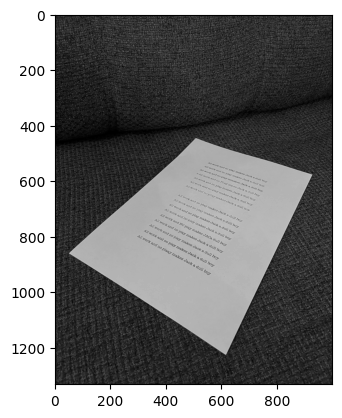

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

file_path = 'images/paper.png'
image = cv2.imread(file_path, 0)
plt.imshow(image, cmap='gray')

**Exercise 9.1**

Find the corners of the paper using traditional CV techniques.

Expected output:

|Corner|x|y|
|---|---|---|
|c1|506|447|
|c2|927|578|
|c3|613|1227|
|c4|50|862|

Visual check:

<img src='images/paper_corners.png'>

In [2]:
blur = cv2.GaussianBlur(image, (5, 5), 0)
_, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

kernel = np.ones((3, 3), np.uint8)
th_clean = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)

contours, hierarchy = cv2.findContours(th_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
paper_contour = max(contours, key=cv2.contourArea)

In [31]:
peri   = cv2.arcLength(paper_contour, True)
approx = cv2.approxPolyDP(paper_contour, 0.02 * peri, True)

if len(approx) == 4:
    corners = approx.reshape(4, 2)
else:
    rect = cv2.minAreaRect(paper_contour)
    corners = cv2.boxPoints(rect)
    corners = np.intp(corners)

pts = np.array(corners, dtype="float32")
y_sorted = pts[np.argsort(pts[:, 1])]
top, bottom = y_sorted[:2], y_sorted[2:]
tl, tr = top[np.argsort(top[:, 0])]
bl, br = bottom[np.argsort(bottom[:, 0])]
corners = np.array([tl, tr, br, bl], dtype="float32")

c1, c2, c3, c4 = corners

(-0.5, 999.5, 1332.5, -0.5)

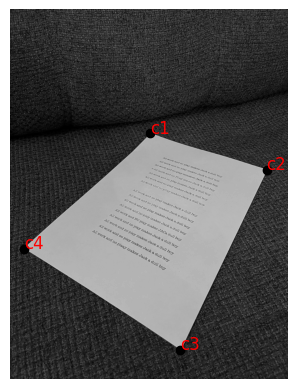

In [32]:
image = cv2.imread(file_path, 0)
plt.imshow(image, cmap='gray')
corner_id = 1
for x, y in [c1, c2, c3, c4]:
    plt.scatter(x, y, color='black')
    plt.text(x, y, f'c{corner_id}', fontsize=12, color='red')
    corner_id += 1
plt.axis('off')

In [40]:
import pandas as pd
coords = np.round(np.vstack([c1, c2, c3, c4])).astype(int)

# build dataframe
df = pd.DataFrame(coords, columns=["x", "y"], index=["c1", "c2", "c3", "c4"])
df.index.name = 'Corner'
df

,x,y
Corner,,
c1,506,447
c2,925,578
c3,614,1227
c4,51,863


## 9.2 The problem

Paper is rectangle therefore we know that $|c1c2|=|c3c4|$ and $|c1c4|=|c2c3|$.

**Exercise 9.2**

Calculate the lengths of the 4 lines and check if the equalities $|c1c2|=|c3c4|$ and $|c1c4|=|c2c3|$ are true.

In [41]:
# YOUR CODE HERE
def dist(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

top = dist(c1, c2)
bottom = dist(c3, c4)
left = dist(c1, c4)
right = dist(c2, c3)

if top == bottom:
    print("Top is equal to bottom")
else:
    print("Top is NOT equal to bottom")

if left == right:
    print("Left is equal to right")
else:
    print("Left is NOT equal to right")

Top is NOT equal to bottom
Left is NOT equal to right


They are not equal! Does this mean the A4 paper, which we know is a rectangle, might not actually be a rectangle? 🤯 Absolutely not! It's still a rectangle; what we're seeing is the effect of perspective.

## 9.3 Homography

We will use the homography to correct the distortion:

<img src='images/corrected_image.jpg' width=400>

Watch the following video before moving on, it explains what homography is, its theory and its implementation with Python + OpenCV.

[Image analysis: homography: planar homography](https://www.youtube.com/watch?v=1PJZNCU9yRo)



- Step 1: Define the image coordinates
- Step 2: Define the world coordinates
- Step 2: Find the homography matrix
- Step 3: Warp the image with the homography matrix


**Exercise 9.3**

Create a numpy array called `image_coordinates`, of size (4, 2). Use the corner coordinates you detected in Exercise 9.1.

Expected output:

```python
array([[ 506,  447],
       [ 927,  578],
       [ 613, 1227],
       [  50,  862]])
```

In [43]:
# YOUR CODE HERE
image_coordinates = np.round(
    np.array([c1, c2, c3, c4])
).astype(int)

image_coordinates

array([[ 506,  447],
       [ 925,  578],
       [ 614, 1227],
       [  51,  863]])

**Exercise 9.4**

Create a numpy array called `world_coordinates`. These are the coordinates of c1, c2, c3, c4 after the transformation. Since we want the output to be a rectangle image with w and h following the aspect ratio of an A4 paper we can simply do the following:

```python
world_coordinates = np.array([
    [0, 0],
    [w - 1, 0],
    [w - 1, h - 1],
    [0, h - 1]])
```

In the video, the instructor used the aspect ratio of the plates to define the world coordinates. For an A4 paper, $\frac{h}{w}=\sqrt{2}$

In [85]:
w = 500 # you can change this to change output resolution
# YOUR CODE HERE
from math import sqrt
h = int(round(sqrt(2) * w))
world_coordinates = np.array([
    [0,0],
    [w-1, 0],
    [w-1, h-1],
    [0, h-1]
])

**Exercise 9.5**

Calculate the homography matrix. In the video, he implemented the solution by least squares. You can use OpenCV as follows:

```H, status = cv2.findHomography(image_coordinates, world_coordinates)```

`H` is the homography matrix. `status` is a binary array, which contains a 0 or 1 for each datapoint. In our case we supplied 4 points. We could have supplied more. It indicates how well the point fits homography calculation. If it is 1, the point is an inliner, if it is 0 the point is an outlier.

Example output:

```python
array([[ 2.83722706e+00,  3.11753142e+00, -2.82917344e+03],
       [-1.61265806e+00,  5.18266446e+00, -1.50064603e+03],
       [ 1.58379133e-04,  3.57326174e-03,  1.00000000e+00]])
```

In [86]:
# YOUR CODE HERE
H, status = cv2.findHomography(image_coordinates, world_coordinates)

H

array([[ 2.81829684e+00,  3.08251217e+00, -2.80394114e+03],
       [-1.60565807e+00,  5.13565444e+00, -1.48317455e+03],
       [ 1.41027729e-04,  3.53849774e-03,  1.00000000e+00]])

**Exercise 9.6**

Use ```cv2.warpPerspective()``` as shown in the video to warp the raw image with the homography matrix.

In [87]:
image = cv2.imread(file_path)
warped_image = cv2.warpPerspective(image, H, (w,h))

(-0.5, 499.5, 706.5, -0.5)

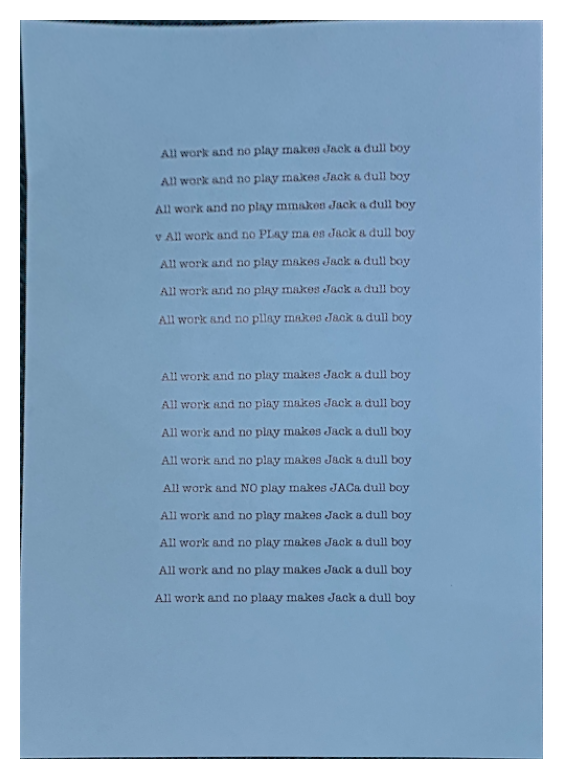

In [88]:
plt.figure(dpi=200)
plt.imshow(warped_image)
plt.axis('off')

## 9.4 Advanced

In this notebook we explored the challenges of measuring objects in a three-dimensional world using two-dimensional imagery. We learned the concept of homography, a transformation describing how 3D spaces are projected onto 2D images by a camera. This is crucial for correcting perspective distortions and understanding spatial relationships in images.

But we have only scratched the surface. If you would like to extend your knowledge in this direction, investigate the following:

- [Camera Calibration](https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html): Learn how to determine the intrinsic and extrinsic parameters of a camera to improve the accuracy of measurements from images.

- [Optical Flow](https://en.wikipedia.org/wiki/Optical_flow): Explore how to track the movement of objects or features in a sequence of images, useful for understanding dynamic scenes.

- [Triangulation](https://en.wikipedia.org/wiki/Triangulation): Understand how to determine the location of a point in 3D space based on its projections in multiple images.

- [Depth Estimation](https://huggingface.co/tasks/depth-estimation): Investigate methods to estimate the depth of objects from images, especially in single-camera setups.

- [Stereo Vision](https://en.wikipedia.org/wiki/Computer_stereo_vision): Explore the use of two cameras to obtain depth information by mimicking human binocular vision.

- [3D Reconstruction](https://en.wikipedia.org/wiki/3D_reconstruction): Learn about reconstructing 3D models of objects or environments from 2D images.